In [1]:
import os
import glob
import operator as op

import numpy             as np
import matplotlib.pyplot as plt

from CCfun  import in_range
from CCfun  import compute_baseline_float
from CCfun  import datetime_from_spectrum

from CCplot import plot1d
from CCplot import plot_line
from CCplot import auto_plot_style
from CCplot import figure_sizes
from CCplot import subplots

from CCfit  import shifted_gauss
from CCfit  import shifted_expo
from CCfit  import fit

from CCio import load_ccd_file

In [2]:
maindir = "/home/gonzalo/data/CC/Consistency/"

auto_plot_style({"lines.markersize" : 10})

In [3]:
def lmap(*args):
    return list(map(*args))

def npmap(*args):
    return np.array(lmap(*args))

def orderer(filename):
    basename = filename.split("/")[-1]
    tokens   = basename.split("_")
    index    = 0
    for token in tokens:
        if token[0].isdigit():
            index = 100 * index + int(token)
    return index

def find_max(x, y):
    m  = in_range(x, 600, 1000)
    return y[m].max()

def integrate(emwl, spectrum, rebin_by=1):
    x  = emwl
    y  = spectrum
    y -= compute_baseline_float(y)
    if rebin_by > 1:
        x = rebin(x, rebin_by, np.mean)
        y = rebin(y, rebin_by, np.sum )
    
    s  = find_max(x, y), 770,  30,  0
    f  = fit(shifted_gauss, x, y, s, fit_range = (600, 1000), maxfev=int(1e6))
    #plt.plot(x, y, "k.")
    #plt.plot(x, f.fn(x), "b-")
    return f.values[0] * np.diff(x)[0]

def fit_selfbleach(x, y):
    s  = 1e9, -50, 5e9
    f  = fit(shifted_expo, x, y, s, maxfev=int(1e6))
    plt.scatter(x, y)
    plt.plot(x, f.fn(x), "y-")
    return f.values[0], -f.values[1], f.values[2]

# Same position, nothing moved, repeated measurements

In [4]:
filenames = sorted(glob.glob(os.path.join(maindir, "Constant", "*signal*")), key=orderer)
datas     =  lmap(load_ccd_file, filenames)
em_wls    =  lmap(op.attrgetter("em_wl"), datas)
times     = npmap(datetime_from_spectrum, datas)
times     = npmap(op.attrgetter("seconds"), times - times[0]) * 1.0
spectra   = [s.rate / s.power.mean for s in datas]
peaks     = npmap(find_max, em_wls, spectra)
integrals = npmap(integrate, em_wls, spectra)

Text(0, 0.5, 'Integral')

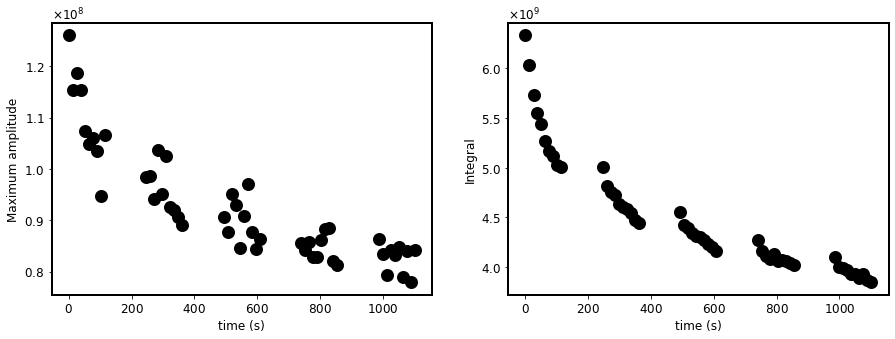

In [5]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.scatter(times, peaks)
plt.xlabel("time (s)")
plt.ylabel("Maximum amplitude")


plt.subplot(1, 2, 2)
plt.scatter(times, integrals)
plt.xlabel("time (s)")
plt.ylabel("Integral")

/home/gonzalo/sw/git/CC/CCfit.py:42: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(cov))


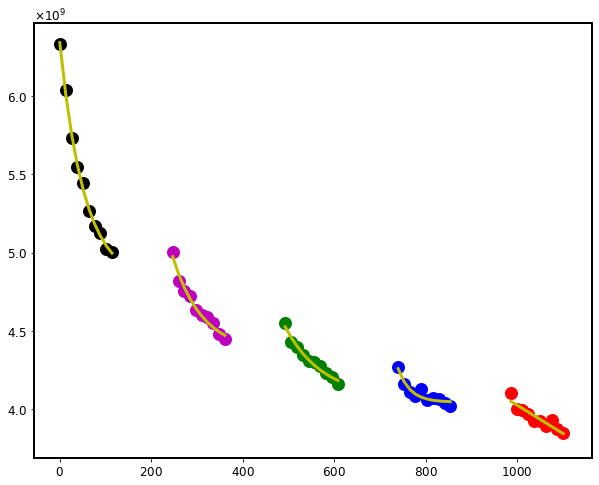

In [6]:
scales, bleachs, offsets = zip(*map(fit_selfbleach, np.split(times, 5), np.split(integrals, 5)))

(1895752374.050548, 305.2764298392732, 3938436986.0541863)

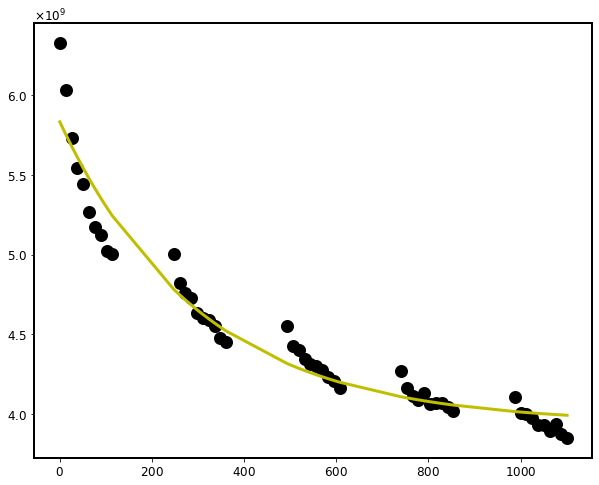

In [7]:
fit_selfbleach(times, integrals)

Text(0.5, 1.0, 'offset')

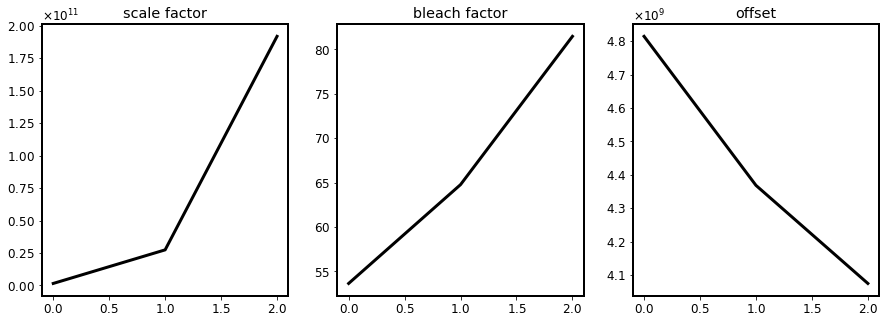

In [8]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(scales[:3])
plt.title("scale factor")

plt.subplot(1, 3, 2)
plt.plot(bleachs[:3])
plt.title("bleach factor")

plt.subplot(1, 3, 3)
plt.plot(offsets[:3])
plt.title("offset")

# Same position, take out and put back

In [9]:
filenames = sorted(glob.glob(os.path.join(maindir, "Takeout", "*signal*")), key=orderer)
datas     =  lmap(load_ccd_file, filenames)
del datas[2]
em_wls    =  lmap(op.attrgetter("em_wl"), datas)
times     = npmap(datetime_from_spectrum, datas)
times     = npmap(op.attrgetter("seconds"), times - times[0]) * 1.0
spectra   = [s.rate / s.power.mean for s in datas]
peaks     = npmap(find_max, em_wls, spectra)
integrals = npmap(integrate, em_wls, spectra)

Text(0, 0.5, 'Integral')

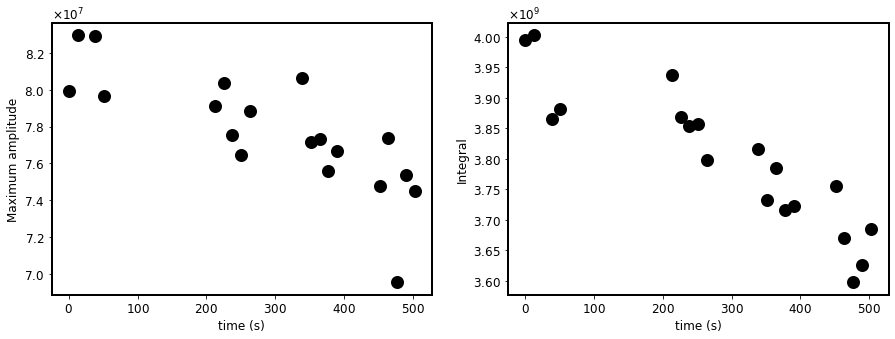

In [10]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.scatter(times, peaks)
plt.xlabel("time (s)")
plt.ylabel("Maximum amplitude")


plt.subplot(1, 2, 2)
plt.scatter(times, integrals)
plt.xlabel("time (s)")
plt.ylabel("Integral")

# Different positions in the wheel

In [15]:
filenames = sorted(glob.glob(os.path.join(maindir, "Positions", "*signal*")), key=orderer)
datas     =  lmap(load_ccd_file, filenames)
em_wls    =  lmap(op.attrgetter("em_wl"), datas)
times     = npmap(datetime_from_spectrum, datas)
times     = npmap(op.attrgetter("seconds"), times - times[0]) * 1.0
spectra   = [s.rate / s.power.mean for s in datas]
peaks     = npmap(find_max, em_wls, spectra)
integrals = npmap(integrate, em_wls, spectra)

[3.59657251e+09 5.26197908e+09 4.50945873e+09 3.54644733e+09
 3.92451181e+09 4.68942638e+09 3.90299400e+09 3.70297055e+09]


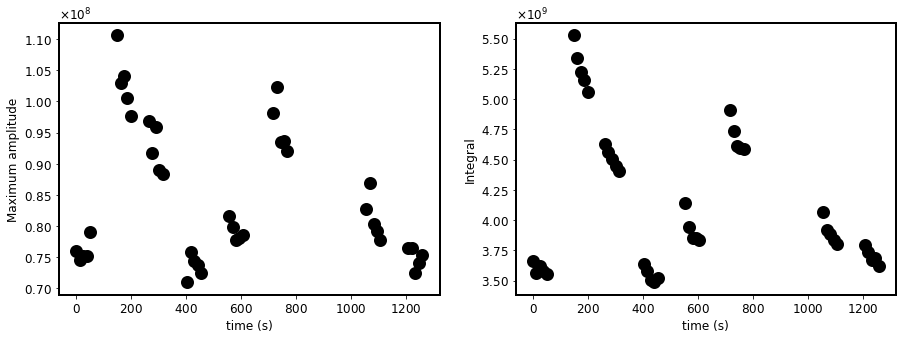

In [17]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.scatter(times, peaks)
plt.xlabel("time (s)")
plt.ylabel("Maximum amplitude")


plt.subplot(1, 2, 2)
plt.scatter(times, integrals)
plt.xlabel("time (s)")
plt.ylabel("Integral")

print(np.reshape(integrals, (8, 5)).mean(axis=1))

# UV bleaching

In [13]:
filenames = sorted(glob.glob(os.path.join(maindir, "Bleaching", "*signal*")), key=orderer)
datas     =  lmap(load_ccd_file, filenames)
em_wls    =  lmap(op.attrgetter("em_wl"), datas)
times     = npmap(datetime_from_spectrum, datas)
times     = npmap(op.attrgetter("seconds"), times - times[0]) * 1.0
spectra   = [s.rate / s.power.mean for s in datas]
peaks     = npmap(find_max, em_wls, spectra)
integrals = npmap(integrate, em_wls, spectra)

Text(0, 0.5, 'Integral')

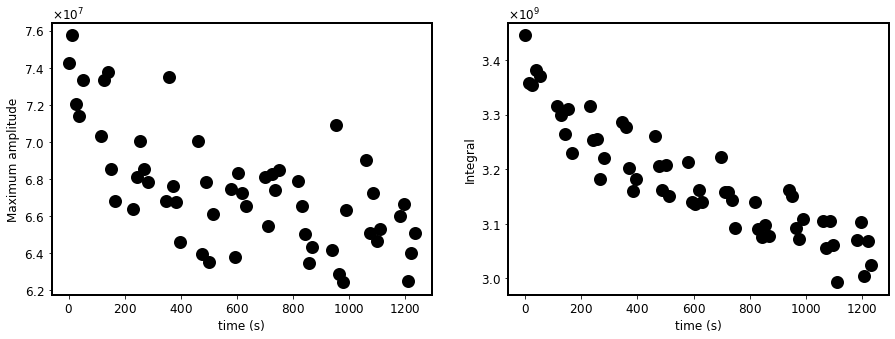

In [14]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.scatter(times, peaks)
plt.xlabel("time (s)")
plt.ylabel("Maximum amplitude")


plt.subplot(1, 2, 2)
plt.scatter(times, integrals)
plt.xlabel("time (s)")
plt.ylabel("Integral")